In [1]:
from downscaling.pipeline import DownscalingPipeline
from IPython.display import display

from visualization.climate_data_visualizer import ClimateDataVisualizer
from visualization.evaluation_visualizer import EvaluationVisualization
from utility.utility import save_to_json
from model.modelconfig import UNetModelConfiguration

In [2]:
%reload_ext autoreload
%autoreload 2

### Definition of Parameters and Hyperparamters
Loads data_params file 

Set Hyperparameters

## Data Preperation 
This steps consits of loading the dataset, preprocessing and data splitting step.

In [2]:
# FIXME: Add Infos to Data Loading, what data, how does it look etc. 
# FIXME: Explain shortly how the data is preprocessed. Both Metrics
# FIXME: Explain how the data is splitted, which ratio. Evtl. store the data
# FIXME: Explain Model, how input shape is defined 
# FIXME: Explain different Evaluation Visualization parts

### Data Loading 

In [3]:
# load data
pipeline = DownscalingPipeline('standardized_anomalies')
era5, era5_lsm_orog = pipeline.load_era5()
cerra, cerra_lsm_orog = pipeline.load_cerra()

era5_backup, era5_lsm_orog_backup = era5.copy(), era5_lsm_orog.copy() 
cerra_backup, cerra_lsm_orog_backup = cerra.copy(), cerra_lsm_orog.copy() 

Loading dataset from URL: http://rheissenberger.com/bac/era5/t2m_era5_200605_025deg.nc


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Loading dataset from URL: http://rheissenberger.com/bac/era5/t2m_era5_lsm_geop_201801_025deg.nc
Loading dataset from URL: http://rheissenberger.com/bac/cerra/t2m_cerra_200605_005deg.nc
Loading dataset from URL: http://rheissenberger.com/bac/cerra/t2m_cerra_lsm_orog_201801_005deg.nc


In [4]:
# show data
print("ERA5 DS:")
display(era5)
display(era5_lsm_orog)
print("\nCERRA DS:")
display(cerra)
display(cerra_lsm_orog)

ERA5 DS:


<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 221, time: 248)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2006-05-01 ... 2006-05-31T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 256.9 256.9 ... 305.0 305.6
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 06:55:03 GMT by grib_to_netcdf-2.28.0: grib_to_n...

<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 221, time: 1)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2018-01-01T12:00:00
Data variables:
    lsm        (time, latitude, longitude) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    z          (time, latitude, longitude) float32 1.797e+04 ... 7.262e+03
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 13:10:31 GMT by grib_to_netcdf-2.28.0: grib_to_n...


CERRA DS:


<xarray.Dataset>
Dimensions:    (longitude: 801, latitude: 501, time: 248)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.95 -9.9 -9.85 ... 29.9 29.95 30.0
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... 35.1 35.05 35.0
  * time       (time) datetime64[ns] 2006-05-01 ... 2006-05-31T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 281.3 281.3 ... 295.4 295.4
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 08:00:36 GMT by grib_to_netcdf-2.28.0: grib_to_n...

<xarray.Dataset>
Dimensions:    (longitude: 801, latitude: 501, time: 1)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.95 -9.9 -9.85 ... 29.9 29.95 30.0
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... 35.1 35.05 35.0
  * time       (time) datetime64[ns] 2018-01-01T12:00:00
Data variables:
    lsm        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    orog       (time, latitude, longitude) float32 0.2687 0.3937 ... -0.1063
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 12:55:13 GMT by grib_to_netcdf-2.28.0: grib_to_n...

#### Cropping Datasets - Debugging
In the following section, the climate datasets (ERA5 and CERRA) are cropped to a smaller size before preprocessing. This step allows a easier and faster debugging during the development process

In [5]:
crop_size_lon = 77
crop_size_lat = 90
crop_size_time = 56#88

start_idx_era5 = 0
start_idx_cerra = 0

era5 = era5_backup.isel(
    longitude=slice(start_idx_era5, crop_size_lon),
    latitude=slice(start_idx_era5, crop_size_lat),
    time=slice(start_idx_era5, crop_size_time)
)

era5_lsm_orog = era5_lsm_orog_backup.isel(
    longitude=slice(start_idx_era5, crop_size_lon),
    latitude=slice(start_idx_era5, crop_size_lat),
    time=slice(0, crop_size_time)
)

cerra = cerra_backup.isel(
    longitude=slice(start_idx_cerra, crop_size_lon),
    latitude=slice(start_idx_cerra, crop_size_lat),
    time=slice(start_idx_cerra, crop_size_time)
)

cerra_lsm_orog = cerra_lsm_orog_backup.isel(
    longitude=slice(start_idx_cerra, crop_size_lon),
    latitude=slice(start_idx_cerra, crop_size_lat),
    time=slice(0, crop_size_time)
)

In [6]:
# show data
print("ERA5 DS:")
display(era5)
display(era5_lsm_orog)
print("\nCERRA DS:")
display(cerra)
display(cerra_lsm_orog)

ERA5 DS:


<xarray.Dataset>
Dimensions:    (longitude: 77, latitude: 90, time: 56)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... -6.5 -6.25 -6.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 53.25 53.0 52.75
  * time       (time) datetime64[ns] 2006-05-01 ... 2006-05-07T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 256.9 256.9 ... 282.4 282.5
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 06:55:03 GMT by grib_to_netcdf-2.28.0: grib_to_n...

<xarray.Dataset>
Dimensions:    (longitude: 77, latitude: 90, time: 1)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... -6.5 -6.25 -6.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 53.25 53.0 52.75
  * time       (time) datetime64[ns] 2018-01-01T12:00:00
Data variables:
    lsm        (time, latitude, longitude) float32 1.0 1.0 1.0 ... 0.7478 0.3057
    z          (time, latitude, longitude) float32 1.797e+04 1.783e+04 ... 541.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 13:10:31 GMT by grib_to_netcdf-2.28.0: grib_to_n...


CERRA DS:


<xarray.Dataset>
Dimensions:    (longitude: 77, latitude: 90, time: 56)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.95 -9.9 -9.85 ... -6.3 -6.25 -6.2
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... 55.65 55.6 55.55
  * time       (time) datetime64[ns] 2006-05-01 ... 2006-05-07T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 281.3 281.3 ... 284.2 283.9
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 08:00:36 GMT by grib_to_netcdf-2.28.0: grib_to_n...

<xarray.Dataset>
Dimensions:    (longitude: 77, latitude: 90, time: 1)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.95 -9.9 -9.85 ... -6.3 -6.25 -6.2
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... 55.65 55.6 55.55
  * time       (time) datetime64[ns] 2018-01-01T12:00:00
Data variables:
    lsm        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    orog       (time, latitude, longitude) float32 0.2687 0.3937 ... -1.981
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 12:55:13 GMT by grib_to_netcdf-2.28.0: grib_to_n...

#### Visualizing Dataset

**Note:**
CERRA data doesn't cover the north of europe! 

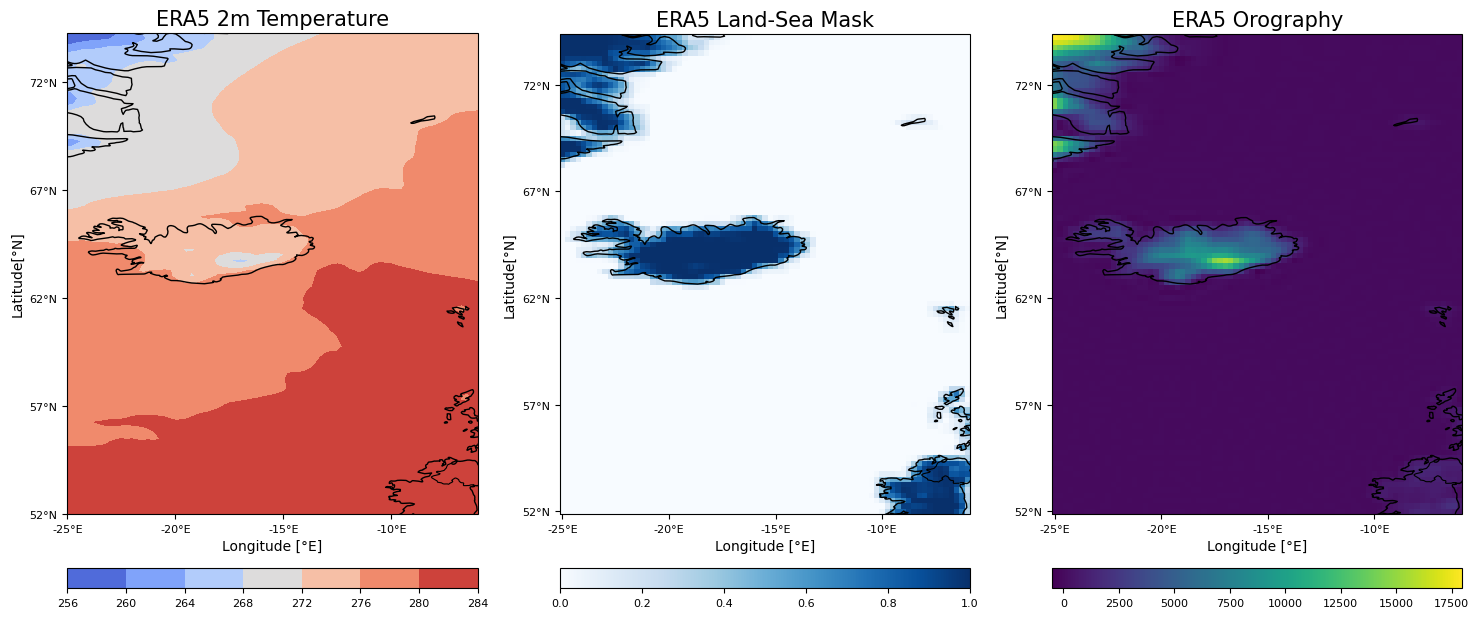

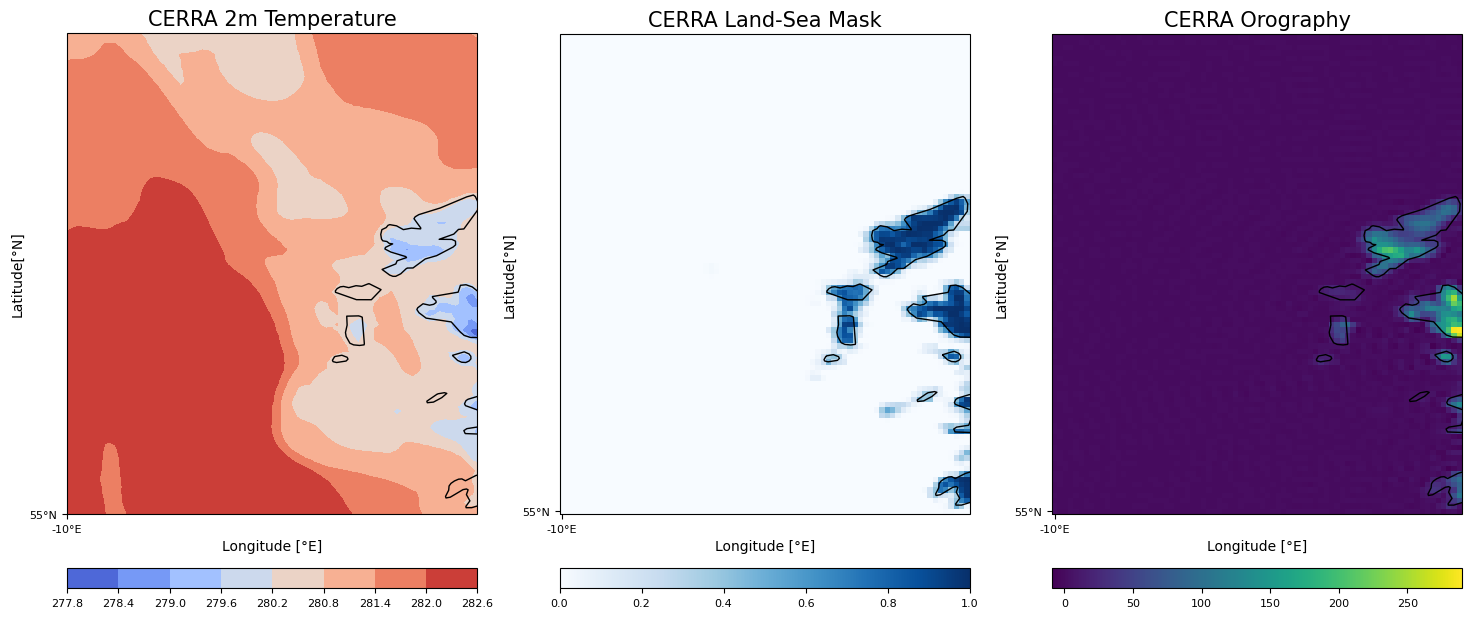

In [7]:
map_visualizer = ClimateDataVisualizer()
map_visualizer.plot_climate_data(era5, era5_lsm_orog, cerra, cerra_lsm_orog)

### Data Preprocessing 

In [8]:
preprocessed_lr_data, preprocessed_hr_data = pipeline.preprocess_data(era5, cerra, era5_lsm_orog, cerra_lsm_orog)

In [ ]:
# show data 
print("ERA5 DS preprocessed:")
display(preprocessed_lr_data)

print("\nCERRA DS preprocessed:")
display(preprocessed_hr_data)

### Data Splitting

In [9]:
# Perform Splitting
lr_train_data, lr_val_data, lr_test_data, hr_train_data, hr_val_data, hr_test_data = pipeline.split_data(preprocessed_lr_data, preprocessed_hr_data)

In [ ]:
# Calculate ratios
total_lr_data = len(preprocessed_lr_data.time)
total_hr_data = len(preprocessed_lr_data.time)

ratio_lr_train = len(lr_train_data.time) / total_lr_data
ratio_lr_val = len(lr_val_data.time) / total_lr_data
ratio_lr_test = len(lr_test_data.time) / total_lr_data

ratio_hr_train = len(hr_train_data.time) / total_hr_data
ratio_hr_val = len(hr_val_data.time) / total_hr_data
ratio_hr_test = len(hr_test_data.time) / total_hr_data

# Print ratios
print(f"Low-Resolution Data Ratios:")
print(f"Train: {ratio_lr_train:.2%}, Validation: {ratio_lr_val:.2%}, Test: {ratio_lr_test:.2%}")

print("\nHigh-Resolution Data Ratios:")
print(f"Train: {ratio_hr_train:.2%}, Validation: {ratio_hr_val:.2%}, Test: {ratio_hr_test:.2%}")

## Model Setup
This step consits of model creation and training. 

In [10]:
filename_suffix = ''
last_idx = 50

### Creation of the Model

In [11]:
scheduler_types = ['step_decay', 'exponential_decay', 'time_decay'] # FIXME: removed constant, might only try it once, to include in thesis & tell how bad
learning_rate_values = [1e-2, 1e-3, 1e-4]
loss_types = ['mse', 'mae', 'huber_loss'] #, 'log_cosh', 'mean_squared_logarithmic_error']
num_epochs_list = [20, 30, 50]
batch_sizes = [16, 32, 64]
initial_filters = [16, 32, 56, 64]

In [12]:
initial_filter = initial_filters[1]
print(initial_filter)

model_configuration = UNetModelConfiguration()
filters = model_configuration.generate_filters(initial_filter)
print(filters)

32
[32, 64, 128, 256, 512]


In [36]:
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[1]

num_epochs = num_epochs_list[0]
batch_size = batch_sizes[1]

loss_type = loss_types[1] #mae better than mse 

# saving to json file
model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', #FIXME: change accordingly
    'note': '4 blocks of encoder & decoder'
}

In [37]:
# create model 
model = pipeline.fit_model(X_train=lr_train_data, y_train=hr_train_data, X_val=lr_val_data, y_val=hr_val_data, 
                           scheduler_type=scheduler_type, learning_rate_value=learning_rate_value, 
                           num_epochs=num_epochs, batch_size=batch_size, loss_type=loss_type, filters=filters,
                           additional_features=False)

last_idx += 1
filename_suffix = last_idx
print(filename_suffix)

[<KerasTensor: shape=(None, 90, 76, 64) dtype=float32 (created by layer 'activation_85')>, <KerasTensor: shape=(None, 90, 76, 128) dtype=float32 (created by layer 'activation_83')>, <KerasTensor: shape=(None, 90, 76, 256) dtype=float32 (created by layer 'activation_81')>, <KerasTensor: shape=(None, 90, 76, 512) dtype=float32 (created by layer 'activation_79')>]
Epoch 1/20
2/2 [==============================] - 98s 30s/step - loss: 0.7228 - val_loss: 0.6667 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 113s 33s/step - loss: 0.6837 - val_loss: 0.6878 - lr: 0.0010
Epoch 3/20


### Model's History Plot

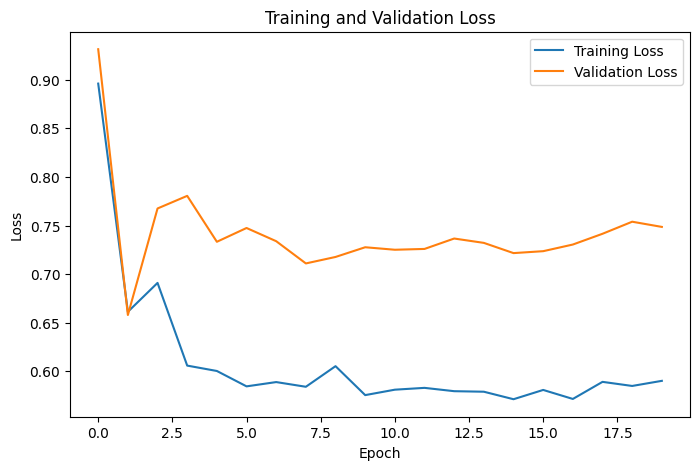

In [27]:
pipeline.show_training_history(filename_suffix)

## Prediction & Evaluation

### Prediction

In [28]:
result = pipeline.predict(lr_test_data)

1/1 [==============================] - 3s 3s/step


In [ ]:
hr_test_denormalized = pipeline.denormalize(hr_test_data)
metric_results = pipeline.evaluate_prediction(hr_test_denormalized, result)


Metrics:
╒═════════╤══════════╤═════════════╤═══════════╕
│    RMSE │      MAE │   Max Error │      Bias │
╞═════════╪══════════╪═════════════╪═══════════╡
│ 1.08549 │ 0.928018 │     6.14017 │ -0.452345 │
╘═════════╧══════════╧═════════════╧═══════════╛


### Evaluation

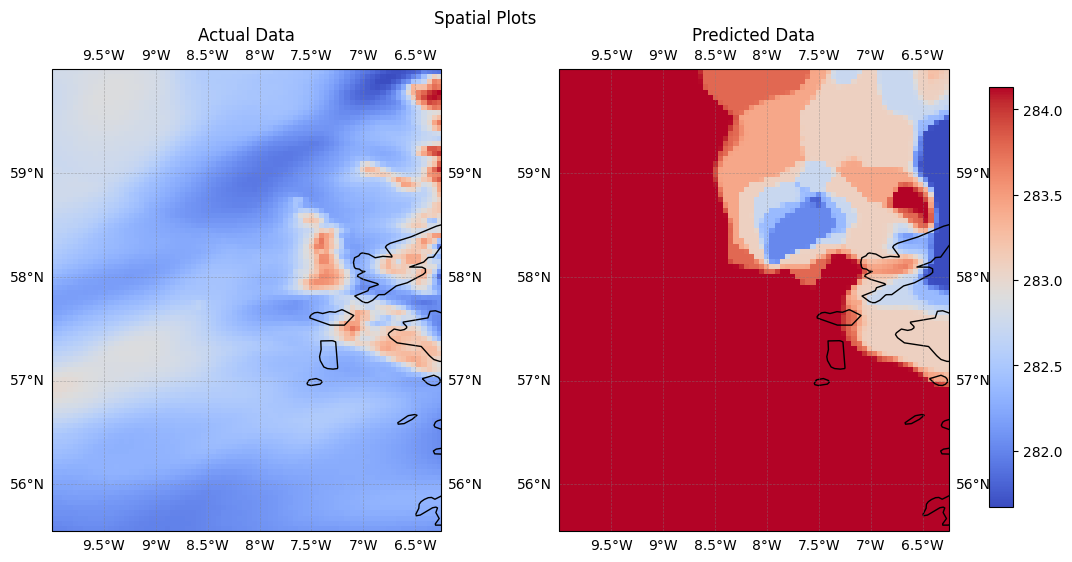

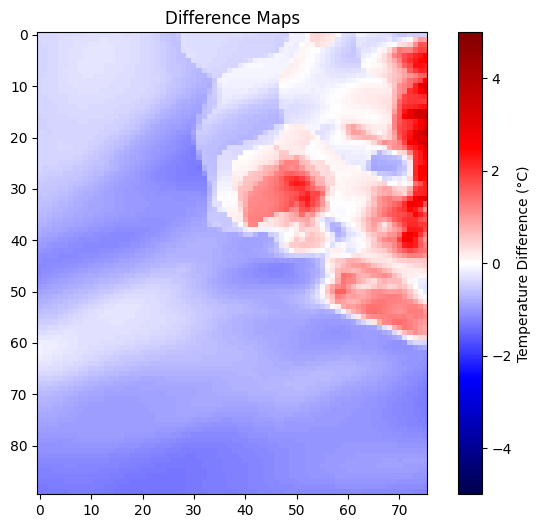

[283.5833  283.5965  283.6126  ... 282.99673 282.9899  282.98404]
[284.12906 284.12906 284.12906 ... 284.12906 284.12906 284.12906]


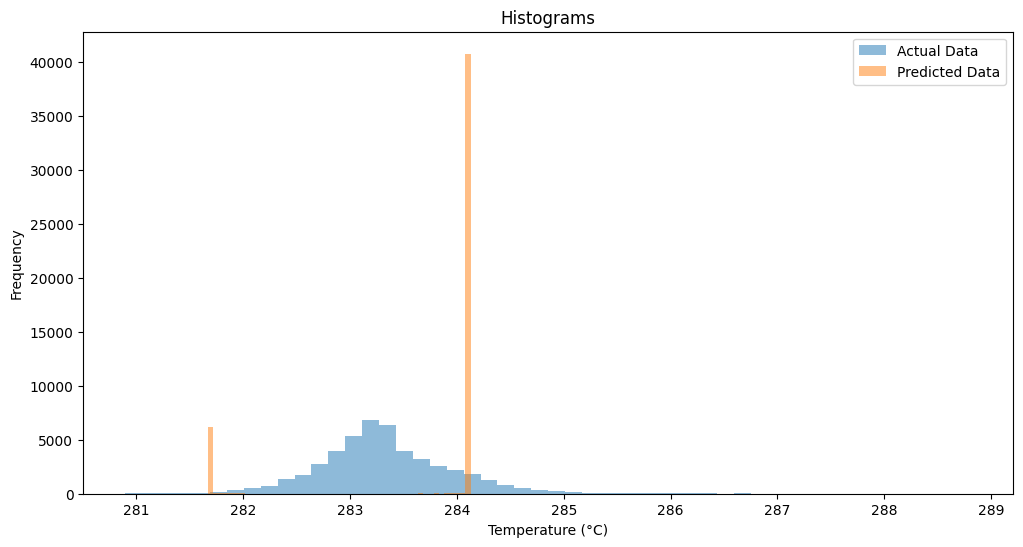

In [30]:
# show plots etc. 
visualizer = EvaluationVisualization()

visualizer.spatial_plots(hr_test_denormalized, result, filename_suffix)

visualizer.difference_maps(hr_test_denormalized, result, filename_suffix)

visualizer.histograms(hr_test_denormalized, result, filename_suffix)

In [26]:
history = pipeline.get_history()
save_to_json(filename_suffix, model_setup, history['loss'], history['val_loss'], metric_results)

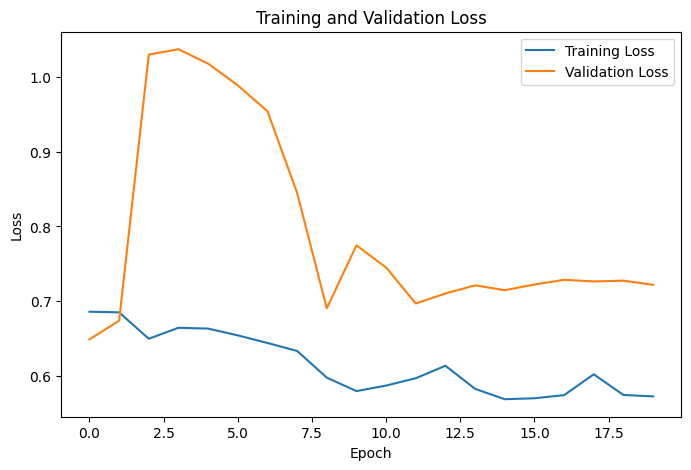

1/1 [==============================] - 3s 3s/step

Metrics:
╒═════════╤══════════╤═════════════╤═══════════╕
│    RMSE │      MAE │   Max Error │      Bias │
╞═════════╪══════════╪═════════════╪═══════════╡
│ 1.00958 │ 0.872341 │      6.0329 │ -0.542427 │
╘═════════╧══════════╧═════════════╧═══════════╛


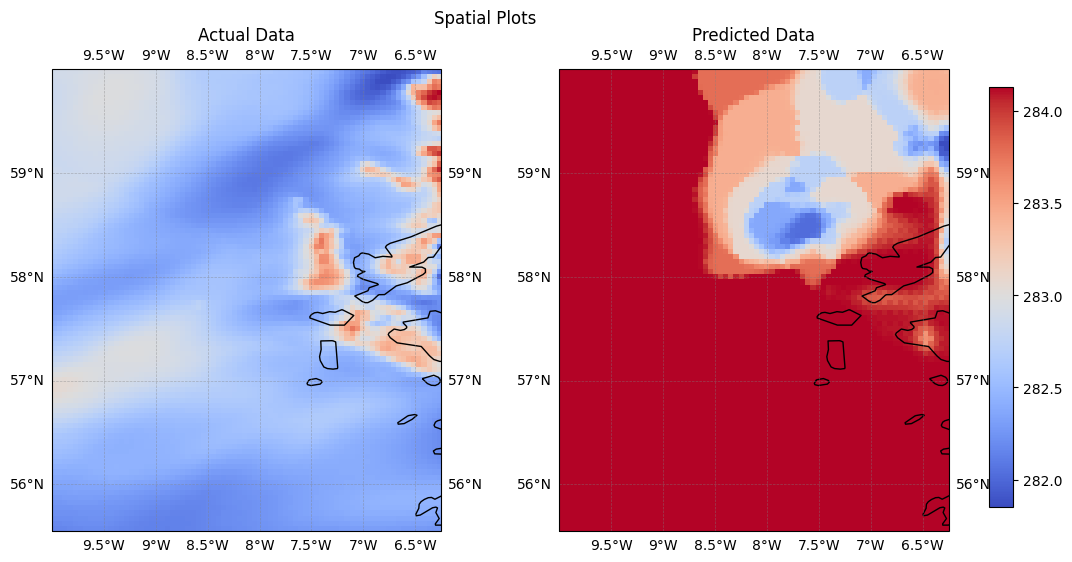

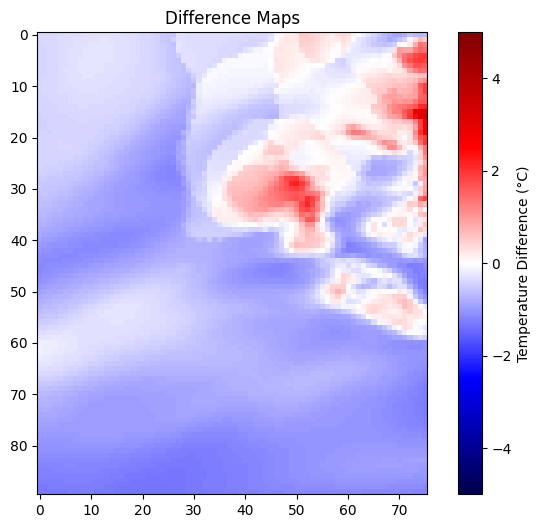

[283.5833  283.5965  283.6126  ... 282.99673 282.9899  282.98404]
[284.12906 284.12906 284.12906 ... 284.12906 284.12906 284.12906]


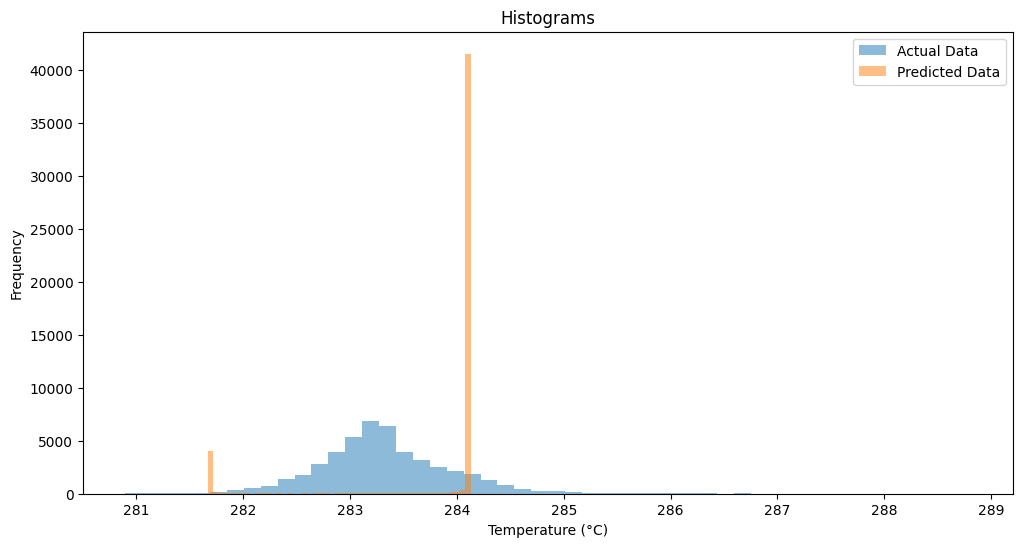

In [34]:
# show & save training history
pipeline.show_training_history(filename_suffix)

# predicte unseen t2m hr data
result = pipeline.predict(lr_test_data)

hr_test_denormalized = pipeline.denormalize(hr_test_data)
metric_results = pipeline.evaluate_prediction(hr_test_denormalized, result)

# show plots etc. 
visualizer = EvaluationVisualization()

visualizer.spatial_plots(hr_test_denormalized, result, filename_suffix)
visualizer.difference_maps(hr_test_denormalized, result, filename_suffix)
visualizer.histograms(hr_test_denormalized, result, filename_suffix)

# save results to json file
history = pipeline.get_history()
save_to_json(filename_suffix, model_setup, history['loss'], history['val_loss'], metric_results)

# Fine Tuning

## Try only once:
- constant learning rate 
- Log-cosh and mean squared logarithmic error are more suitable for tasks with skewed distributions.


## Removed completley + Reason:
- **Loss weights** can be important if you have multiple loss terms. For regression, you might have a single loss term (e.g., mean squared error) without explicit weighting. In some cases, you may want to assign higher weights to certain samples or time points if they are more important.



## General Infos:
The **number of epochs** determines how many times the model goes through the entire training dataset. Too few epochs may lead to underfitting, while too many epochs may lead to overfitting. It's often a good idea to monitor the training and validation loss to determine the optimal number of epochs.

**Batch size** influences the stability and speed of convergence during training. Smaller batch sizes introduce more noise into the optimization process and may act as a regularizer. Larger batch sizes may lead to faster convergence but might miss fine details in the data.

In [ ]:
import itertools

show_graph = False

# Define hyperparameter values
filename_suffix_base = 'sa'
scheduler_types = ['step_decay', 'exponential_decay', 'time_decay'] # FIXME: removed constant, might only try it once, to include in thesis & tell how bad
learning_rate_values = [1e-2, 1e-3, 1e-4]
loss_types = ['mse', 'mae', 'huber_loss'] #, 'log_cosh', 'mean_squared_logarithmic_error']
num_epochs_list = [20, 30, 50]
batch_sizes = [16, 32, 64]

# Generate combinations of hyperparameter values (in total 100)
hyperparameter_combinations = itertools.product(scheduler_types, learning_rate_values, 
                                               num_epochs_list, batch_sizes, 
                                               loss_types)

# Print the generated combinations
#for i, params in enumerate(hyperparameter_combinations, 1):
#    print(f"Combination {i:02d}: {params}")

# Execute the pipeline for each combination
for i, params in enumerate(hyperparameter_combinations):
    print(f"Combination {i:02d}: {params}")

    scheduler_type, learning_rate_value, num_epochs, batch_size, loss_type = params
    
    filename_suffix = f'{filename_suffix_base}_{i:02d}'
    
    # Set up model
    model_setup = {
        'scheduler_type': scheduler_type,
        'learning_rate_value': learning_rate_value,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'loss_type': loss_type
    }

    model = pipeline.fit_model(X_train=lr_train_data, y_train=hr_train_data, X_val=lr_val_data, y_val=hr_val_data, 
                           scheduler_type=scheduler_type, learning_rate_value=learning_rate_value, 
                           num_epochs=num_epochs, batch_size=batch_size, loss_type=loss_type,
                           additional_features=False)

    # Execute pipeline
    pipeline.show_training_history(filename_suffix, show_graph)
    result = pipeline.predict(lr_test_data)
    hr_test_denormalized = pipeline.denormalize(hr_test_data)
    metric_results = pipeline.evaluate_prediction(hr_test_denormalized, result)
    
    # Show plots etc.
    visualizer = EvaluationVisualization()
    visualizer.spatial_plots(hr_test_denormalized, result, filename_suffix, show_graph)
    visualizer.difference_maps(hr_test_denormalized, result, filename_suffix, show_graph)
    visualizer.histograms(hr_test_denormalized, result, filename_suffix, show_graph)
    
    # Save to JSON
    history = pipeline.get_history()
    save_to_json(filename_suffix, model_setup, history['loss'], history['val_loss'], metric_results)


**Skip einbauen**
- Varianten bereits getestet, vermerken
- Check einbauen, falls gleiches Setting, dann skippen 

**Vorgehensweise**
- Mit kleineren DS mal laufen lassen 
- Rausfinden, was viel versprechend oder ganz schlecht ist
- Diese mit großen DS probieren
- und dann in Thesis beschreiben 